In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter

def create_super_iterations(time_sample: float, iterations: int):
    times_list = np.zeros(iterations + 1)
    
    time = time_sample
    
    for i in range(0, iterations+1):
        time /= 2  # Halve the time each iteration
        times_list[i] = time
    
    return times_list


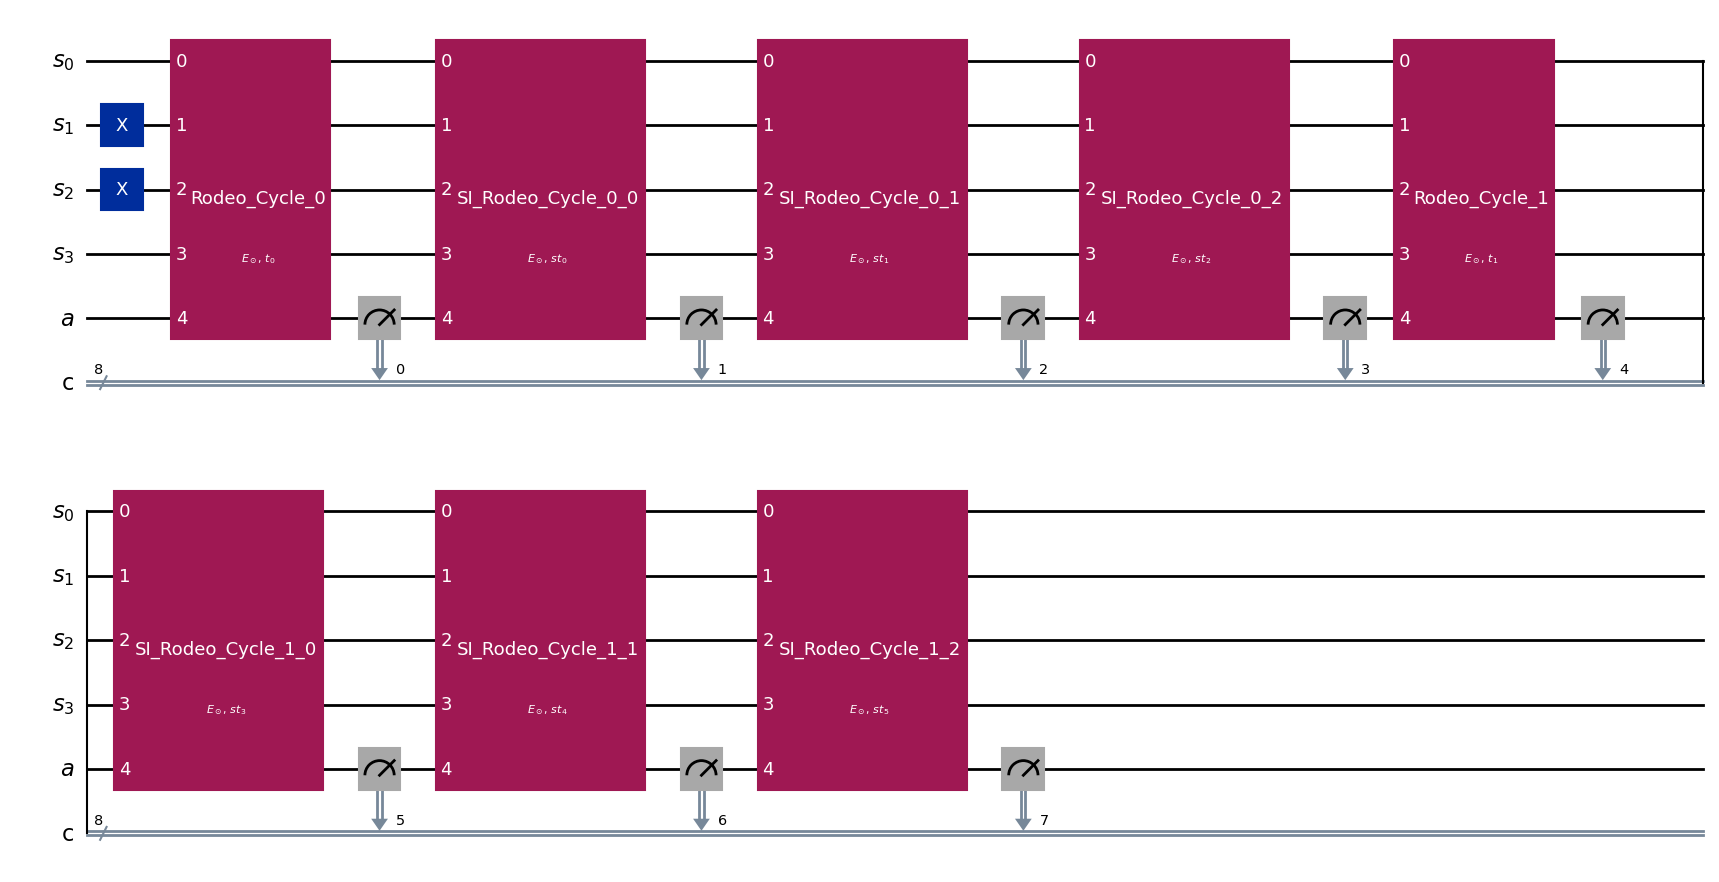

In [9]:
# Define circuit parameters
num_sites = 2
J_input = 4
U_input = 1.0

# Initialize cycling parameters
cycles = 2
iterations = 3

# Initialize Qiskit parameters
target = Parameter(r'$E_\odot$')
time = [Parameter(fr'$t_{i}$') for i in range(cycles)]
si_time = [Parameter(fr'$st_{j}$') for j in range(cycles * iterations)]
steps = 5

# Create registers and circuit
classical = ClassicalRegister(cycles * (1 + iterations), 'c')
aux = QuantumRegister(1, 'a')
sys = QuantumRegister(num_sites * 2, 's')
circuit = QuantumCircuit(sys, aux, classical)

circuit.x([sys[1], sys[2]])

# Create circuit with alternating rodeo cycles and super iterations
classical_idx = 0
super_idx = 0 

for j in range(cycles):
    rodeo_gate = rodeo_cycle(num_sites=num_sites, J_value=J_input, U_value=U_input, t=time[j], r=steps, targ=target)
    circuit.append(rodeo_gate.to_gate(label=fr'Rodeo_Cycle_{j}'), range(num_sites * 2 + 1))
    circuit.measure(aux, classical[classical_idx])
    classical_idx += 1 

    # Add super iteration cycles with si_time
    for k in range(iterations):
        rodeo_gate_si = rodeo_cycle(num_sites=num_sites, J_value=J_input, U_value=U_input, t=si_time[super_idx], r=steps, targ=target)
        circuit.append(rodeo_gate_si.to_gate(label=fr'SI_Rodeo_Cycle_{j}_{k}'), range(num_sites * 2 + 1))
        circuit.measure(aux, classical[classical_idx])
        classical_idx += 1 
        super_idx += 1 

circuit.draw('mpl')


In [10]:
def generate_superiteration_times(tsamples, superiterations, si_time):

    # Validate the size of si_time
    if len(si_time) < len(tsamples) * superiterations:
        raise ValueError("Insufficient si_time parameters for the given cycles and superiterations.")
    
    superiteration_parameter_binds = {}
    

    for i in range(len(tsamples)):

        superiteration_times = []
        time = tsamples[i]
        for _ in range(superiterations):
            time /= 2
            superiteration_times.append(time)
        
        for j in range(superiterations):
            si_index = i * superiterations + j
            superiteration_parameter_binds[si_time[si_index]] = superiteration_times[j]
    
    return superiteration_parameter_binds

Number of target energies: 200
Executing for Target Energy: {Parameter($E_\odot$): -10.0}
Executing for Target Energy: {Parameter($E_\odot$): -9.899497487437186}
Executing for Target Energy: {Parameter($E_\odot$): -9.798994974874372}
Executing for Target Energy: {Parameter($E_\odot$): -9.698492462311558}
Executing for Target Energy: {Parameter($E_\odot$): -9.597989949748744}
Executing for Target Energy: {Parameter($E_\odot$): -9.49748743718593}
Executing for Target Energy: {Parameter($E_\odot$): -9.396984924623116}
Executing for Target Energy: {Parameter($E_\odot$): -9.296482412060302}
Executing for Target Energy: {Parameter($E_\odot$): -9.195979899497488}
Executing for Target Energy: {Parameter($E_\odot$): -9.095477386934673}
Executing for Target Energy: {Parameter($E_\odot$): -8.99497487437186}
Executing for Target Energy: {Parameter($E_\odot$): -8.894472361809045}
Executing for Target Energy: {Parameter($E_\odot$): -8.793969849246231}
Executing for Target Energy: {Parameter($E_\odot

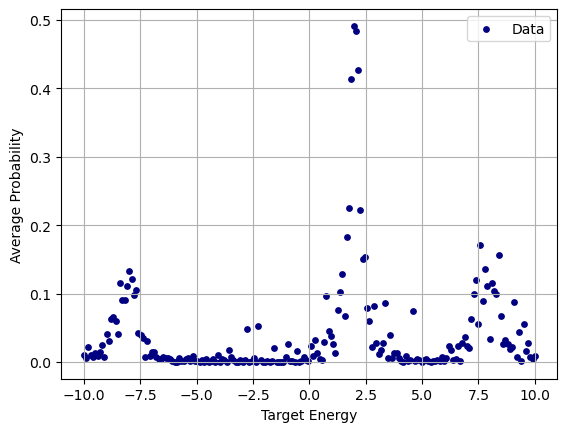

In [13]:
from qiskit_aer.primitives import Sampler
# Enumerate scan energies
energymin = -10
energymax = 10
stepsize = 0.1

targetenergies = np.linspace(energymin, energymax, int((energymax-energymin)/stepsize))
targetenergynum = len(targetenergies)
print("Number of target energies:", targetenergynum)

#Energy window, which should to be slightly larger than stepsize in scan
# Is inverse of sigma parameter
gamma = 0.5

# Amount of "scrambling" of t per target energy. The more random the t the better. 
timeresamples = 10 # Resampling of times for given target energy
shots_per_same_time = 1024

# Create empty list for data
data = []

# Loop through energy list
for i in range(len(targetenergies)):
    
    # Creates dictionary for target energy parameter
    targ_energy = {target : targetenergies[i]}

    # Below is a troubleshooting line you can use to see if the code is scanning through energies properly
    print("Executing for Target Energy:", targ_energy)
    
    # Initialize a list that will contain the results of all 10 resamples for 1 target energy
    targetenergyrun = []
    for _ in range(timeresamples):
        # Creates random time samples for 1 run
        tsamples = ((1 / gamma) * np.random.randn(cycles)).tolist()
        
        # Creates a dictionary to be able to bind time samples to time parameters
        time_parameter_binds = zip(time, tsamples)
        time_parameters = dict(time_parameter_binds)

        superiteration_parameters = generate_superiteration_times(tsamples, superiterations = iterations, si_time=si_time)
        
        # Assigns target energy and time values to parameters
        circuit1 = circuit.assign_parameters(time_parameters, inplace =False)
        circuit2 = circuit1.assign_parameters(targ_energy, inplace = False)
        circuit3 = circuit2.assign_parameters(superiteration_parameters, inplace = False)
        
        # Runs simulation of circuit with values
        sampler = Sampler()
        job = sampler.run(circuit3)
        job.result()
        quasi_dists = job.result().quasi_dists
        
        # Appends the results to list for this target energy
        targetenergyrun.append(quasi_dists)
    
    # The output from above needs to be post-processed as shown below to gain meaning from it:

    # Flattens list of list of dictionaries into just a list of dictionaries
    flattened_list = []
    for sublist in targetenergyrun:
        flattened_list.extend(sublist)

    # Sums and average dictionaries from multiple timeresamples
    combined_dict = {} 
    for dictionary in flattened_list:
        for key, value in dictionary.items():
            combined_dict[key] = combined_dict.get(key, 0) + value

    average_dict = {}
    for key in combined_dict:
        average_dict[key] = combined_dict[key] / timeresamples

    data.append(average_dict)

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# This extracts the probabilities for the 0 bitcounts from our obtained data
values_list = []
for d in data:
    if 0 in d:
        values_list.append(d[0])
    else:
        values_list.append(0.0)
print(len(values_list))
print(len(targetenergies))

# # Define a Gaussian function
# def gaussian(x, amp, cen, wid):
#     return amp * np.exp(-(x-cen)**2 / (2*wid**2))

# # Define a sum of multiple Gaussians
# def sum_of_gaussians(x, *params):
#     n_gaussians = len(params) // 3
#     result = np.zeros_like(x)
#     for i in range(n_gaussians):
#         amp = params[i*3]
#         cen = params[i*3 + 1]
#         wid = params[i*3 + 2]
#         result += gaussian(x, amp, cen, wid)
#     return result

# # Initial guess for the parameters: amplitudes, centers, and widths of the Gaussians
# initial_guess = [
#     1, -6.28, 1,
#     1, -3.45, 1,
#     1, 0, 1,
# ]

# initial_guess = [
#     1, 0,1

# ]

# # Fit the sum of Gaussians to the data
# popt, pcov = curve_fit(sum_of_gaussians, targetenergies, values_list, p0=initial_guess)

# # Extract the fitted parameters
# fitted_params = popt

# # Generate x values for plotting the fit
# x_fit = np.linspace(min(targetenergies), max(targetenergies), 1000)
# y_fit = sum_of_gaussians(x_fit, *fitted_params)

# Plot the data and the fit
plt.scatter(targetenergies, values_list, label='Data', s= 15, color = 'navy')
plt.grid()
plt.xlabel('Target Energy')
plt.ylabel('Average Probability')
# plt.plot(x_fit, y_fit, color = 'red', label = "Gaussian Fit", linestyle = '--')
# plt.axvline(x = -0.44, color = 'green', label = 'Ground Energy', linestyle = '--')

plt.legend()
plt.show()

# Print the peaks (centers) of the Gaussians
# n_gaussians = len(fitted_params) // 3
# peaks = [fitted_params[i*3 + 1] for i in range(n_gaussians)]
# print(f'The peaks (centers) of the Gaussians are at: {peaks}')


We can see that for gamma = 0.5, the inter-peak region is seen to be -6.0 to 0.0 and then 3 to 6. Let's analyze this region.

In [ ]:
from qiskit_aer.primitives import Sampler
# Enumerate scan energies
# energymin = -10
# energymax = 10
# stepsize = 0.1



range1 = np.arange(-6, 0.1, 0.1)
range2 = np.arange(3.5, 6.1, 0.1)  

# targetenergies = np.linspace(energymin, energymax, int((energymax-energymin)/stepsize))
targetenergies = np.concatenate(range1, range2)
targetenergynum = len(targetenergies)
print("Number of target energies:", targetenergynum)

#Energy window, which should to be slightly larger than stepsize in scan
# Is inverse of sigma parameter
gamma = 0.5

# Amount of "scrambling" of t per target energy. The more random the t the better. 
timeresamples = 10 # Resampling of times for given target energy
shots_per_same_time = 1024

# Create empty list for data
data = []

# Loop through energy list
for i in range(len(targetenergies)):
    
    # Creates dictionary for target energy parameter
    targ_energy = {target : targetenergies[i]}

    # Below is a troubleshooting line you can use to see if the code is scanning through energies properly
    print("Executing for Target Energy:", targ_energy)
    
    # Initialize a list that will contain the results of all 10 resamples for 1 target energy
    targetenergyrun = []
    for _ in range(timeresamples):
        # Creates random time samples for 1 run
        tsamples = ((1 / gamma) * np.random.randn(cycles)).tolist()
        
        # Creates a dictionary to be able to bind time samples to time parameters
        time_parameter_binds = zip(time, tsamples)
        time_parameters = dict(time_parameter_binds)

        superiteration_parameters = generate_superiteration_times(tsamples, superiterations = iterations, si_time=si_time)
        
        # Assigns target energy and time values to parameters
        circuit1 = circuit.assign_parameters(time_parameters, inplace =False)
        circuit2 = circuit1.assign_parameters(targ_energy, inplace = False)
        circuit3 = circuit2.assign_parameters(superiteration_parameters, inplace = False)
        
        # Runs simulation of circuit with values
        sampler = Sampler()
        job = sampler.run(circuit3)
        job.result()
        quasi_dists = job.result().quasi_dists
        
        # Appends the results to list for this target energy
        targetenergyrun.append(quasi_dists)
    
    # The output from above needs to be post-processed as shown below to gain meaning from it:

    # Flattens list of list of dictionaries into just a list of dictionaries
    flattened_list = []
    for sublist in targetenergyrun:
        flattened_list.extend(sublist)

    # Sums and average dictionaries from multiple timeresamples
    combined_dict = {} 
    for dictionary in flattened_list:
        for key, value in dictionary.items():
            combined_dict[key] = combined_dict.get(key, 0) + value

    average_dict = {}
    for key in combined_dict:
        average_dict[key] = combined_dict[key] / timeresamples

    data.append(average_dict)

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# This extracts the probabilities for the 0 bitcounts from our obtained data
values_list = []
for d in data:
    if 0 in d:
        values_list.append(d[0])
    else:
        values_list.append(0.0)
print(len(values_list))
print(len(targetenergies))

# # Define a Gaussian function
# def gaussian(x, amp, cen, wid):
#     return amp * np.exp(-(x-cen)**2 / (2*wid**2))

# # Define a sum of multiple Gaussians
# def sum_of_gaussians(x, *params):
#     n_gaussians = len(params) // 3
#     result = np.zeros_like(x)
#     for i in range(n_gaussians):
#         amp = params[i*3]
#         cen = params[i*3 + 1]
#         wid = params[i*3 + 2]
#         result += gaussian(x, amp, cen, wid)
#     return result

# # Initial guess for the parameters: amplitudes, centers, and widths of the Gaussians
# initial_guess = [
#     1, -6.28, 1,
#     1, -3.45, 1,
#     1, 0, 1,
# ]

# initial_guess = [
#     1, 0,1

# ]

# # Fit the sum of Gaussians to the data
# popt, pcov = curve_fit(sum_of_gaussians, targetenergies, values_list, p0=initial_guess)

# # Extract the fitted parameters
# fitted_params = popt

# # Generate x values for plotting the fit
# x_fit = np.linspace(min(targetenergies), max(targetenergies), 1000)
# y_fit = sum_of_gaussians(x_fit, *fitted_params)

# Plot the data and the fit
plt.scatter(targetenergies, values_list, label='Data', s= 15, color = 'navy')
plt.grid()
plt.xlabel('Target Energy')
plt.ylabel('Average Probability')
# plt.plot(x_fit, y_fit, color = 'red', label = "Gaussian Fit", linestyle = '--')
# plt.axvline(x = -0.44, color = 'green', label = 'Ground Energy', linestyle = '--')

plt.legend()
plt.show()

# Print the peaks (centers) of the Gaussians
# n_gaussians = len(fitted_params) // 3
# peaks = [fitted_params[i*3 + 1] for i in range(n_gaussians)]
# print(f'The peaks (centers) of the Gaussians are at: {peaks}')


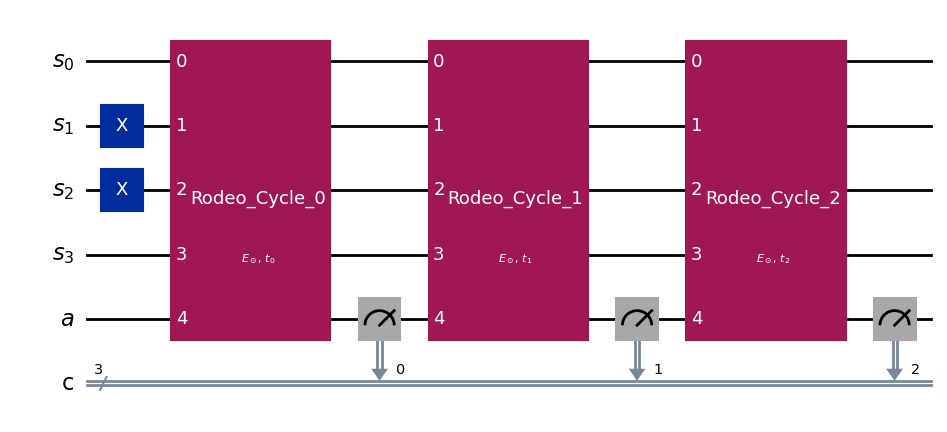

In [14]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter

# # Define Fermi-Hubbard interaction gates for hopping and on-site terms
# Hopping Gate
def create_hopping_gate(J, delta_t):
    f_circ = QuantumCircuit(2)
    f_circ.h([0, 1])
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_circ.cx(0, 1)
    f_circ.h(1)
    f_circ.z(1)
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_gate = f_circ.to_gate(label='F_gate')
    
    g_circ = QuantumCircuit(2)
    g_circ.h([0, 1])
    g_circ.z(0)
    g_circ.s([0, 1])
    g_circ.h(1)
    g_circ.cx(0, 1)
    g_circ.h([0, 1])
    g_circ.z([0, 1])
    g_circ.s([0, 1])
    g_circ.h([0, 1])
    g_gate = g_circ.to_gate(label='G_gate')

    # The code below created a factor of 2 off
    # hop_circ = QuantumCircuit(2)
    # hop_circ.append(f_gate, [0, 1])
    # hop_circ.ry((J * delta_t) / 2, 0)
    # hop_circ.ry((-1*J * delta_t) / 2, 1)
    # hop_circ.append(g_gate, [0, 1])

    hop_circ = QuantumCircuit(2)
    hop_circ.append(f_gate, [0, 1])
    hop_circ.ry((J * delta_t), 0)
    hop_circ.ry((-1*J * delta_t), 1)
    hop_circ.append(g_gate, [0, 1])
    return hop_circ.to_gate(label=fr"A_gate_{J}")

# On-site interaction gate
def create_onsite_gate(U, delta_t):
    onsite_circ = QuantumCircuit(2)
    onsite_circ.cx(0, 1)
    onsite_circ.rz(2*U * delta_t, 1)
    onsite_circ.cx(0, 1)
    return onsite_circ.to_gate(label=fr"B_gate_{U}")

# Define the rodeo cycle
def rodeo_cycle(num_sites, J_value, U_value, t: Parameter, r, targ: Parameter):
    beta = t / r  # Parameter for rotation gates
    num_qubits = num_sites * 2  # Each site has two qubits (spin-up and spin-down)

    # Define quantum registers
    sys = QuantumRegister(num_qubits, 's')
    aux = QuantumRegister(1, 'a')
    qc = QuantumCircuit(sys, aux)

    # Apply Hadamard on the auxiliary qubit to create superposition
    qc.h(aux[0])

    # Trotter evolution within this single Rodeo cycle
    A_gate = create_hopping_gate(J=-J_value, delta_t=beta)
    # A_gate = create_hopping_gate(J=-2*J_value, delta_t=beta)
    B_gate = create_onsite_gate(U=U_value, delta_t=beta)

    qc.cz([sys[0], sys[1]], aux[0])
    for _ in range(r):
    
        # qc.cz([sys[0], sys[1]], aux[0])
        # Apply A_gate for hopping terms on nearest neighbors for spin-up qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            qc.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            qc.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        # Apply A_gate for hopping terms on nearest neighbors for spin-down qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            qc.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            qc.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        # qc.cz([sys[0], sys[1]], aux[0])

        # Add CX gates for every other system qubit
        for i in range(0, num_qubits, 4):
            qc.cx(aux[0], sys[i])  # Controlled X on selected system qubits
            if i + 2 < num_qubits:
                qc.cx(aux[0], sys[i + 2])

        # Apply B_gate for on-site interactions on each site
        for site in range(num_sites):
            spin_up_qubit = site * 2
            spin_down_qubit = site * 2 + 1
            qc.append(B_gate, [spin_up_qubit, spin_down_qubit])

        # # Add CX gates for every other system qubit again
        for i in range(0, num_qubits, 4):
            qc.cx(aux[0], sys[i])  # Controlled X on selected system qubits
            if i + 2 < num_qubits:
                qc.cx(aux[0], sys[i + 2])
        
    qc.cz([sys[0], sys[1]], aux[0])


    # Phase rotation based on the energy target and time sample
    qc.p(2*targ * t, aux[0])
    qc.h(aux[0])

    return qc

def create_super_iterations(time_sample: float, iterations: int):
    times_list = np.zeros(iterations + 1)
    
    time = time_sample
    
    for i in range(0, iterations+1):
        time /= 2  # Halve the time each iteration
        times_list[i] = time
    
    return times_list

# Define circuit parameters
num_sites = 2
J_input = 4.0
U_input = 1.0

# Initialize cycling parameters
cycles = 3
iterations = 0

# Initialize Qiskit parameters
target = Parameter(r'$E_\odot$')
time = [Parameter(fr'$t_{i}$') for i in range(cycles)]
si_time = [Parameter(fr'$st_{j}$') for j in range(cycles * iterations)]
steps = 5

# Create registers and circuit
classical = ClassicalRegister(cycles * (1 + iterations), 'c')
aux = QuantumRegister(1, 'a')
sys = QuantumRegister(num_sites * 2, 's')
circuit = QuantumCircuit(sys, aux, classical)

circuit.x([sys[1], sys[2]])

# Create circuit with alternating rodeo cycles and super iterations
classical_idx = 0
super_idx = 0 

for j in range(cycles):
    rodeo_gate = rodeo_cycle(num_sites=num_sites, J_value=J_input, U_value=U_input, t=time[j], r=steps, targ=target)
    circuit.append(rodeo_gate.to_gate(label=fr'Rodeo_Cycle_{j}'), range(num_sites * 2 + 1))
    circuit.measure(aux, classical[classical_idx])
    classical_idx += 1 

    # Add super iteration cycles with si_time
    for k in range(iterations):
        rodeo_gate_si = rodeo_cycle(num_sites=num_sites, J_value=J_input, U_value=U_input, t=si_time[super_idx], r=steps, targ=target)
        circuit.append(rodeo_gate_si.to_gate(label=fr'SI_Rodeo_Cycle_{j}_{k}'), range(num_sites * 2 + 1))
        circuit.measure(aux, classical[classical_idx])
        classical_idx += 1 
        super_idx += 1 

# Draw the circuit
circuit.draw('mpl')



In [17]:
from qiskit_aer.primitives import Sampler
import numpy as np
from tqdm import tqdm

# Setup parameters
iterations_list = np.arange(1, 11, 1)
cycles_list = [1, 2, 3, 4, 5]
gamma = 0.5

# Define inter-peak regions
range1 = np.arange(-6, 0.1, 0.1)
range2 = np.arange(3.5, 6.1, 0.1)
targetenergies = np.concatenate([range1, range2])

# Parameters for sampling
timeresamples = 10
shots_per_same_time = 1024

# Circuit parameters
num_sites = 2
J_input = 4.0
U_input = 1.0

# Initialize results storage
results = []

for cycles in cycles_list:
    for iterations in iterations_list:
        # Lists to store probabilities for all energies at this (cycles, iterations)
        all_probabilities = []
        
        # Initialize circuit parameters
        target = Parameter(r'$E_\odot$')
        time = [Parameter(fr'$t_{i}$') for i in range(cycles)]
        si_time = [Parameter(fr'$st_{j}$') for j in range(cycles * iterations)]
        steps = 5
        
        # Initialize circuit with registers
        classical = ClassicalRegister(cycles * (1 + iterations), 'c')
        aux = QuantumRegister(1, 'a')
        sys = QuantumRegister(num_sites * 2, 's')
        circuit = QuantumCircuit(sys, aux, classical)
        circuit.x([sys[1], sys[2]])
        
        # Create circuit with alternating rodeo cycles and super iterations
        classical_idx = 0
        super_idx = 0 

        for j in range(cycles):
            rodeo_gate = rodeo_cycle(num_sites=num_sites, J_value=J_input, U_value=U_input, 
                                   t=time[j], r=steps, targ=target)
            circuit.append(rodeo_gate.to_gate(label=fr'Rodeo_Cycle_{j}'), range(num_sites * 2 + 1))
            circuit.measure(aux, classical[classical_idx])
            classical_idx += 1 

            # Add super iteration cycles with si_time
            for k in range(iterations):
                rodeo_gate_si = rodeo_cycle(num_sites=num_sites, J_value=J_input, U_value=U_input,
                                          t=si_time[super_idx], r=steps, targ=target)
                circuit.append(rodeo_gate_si.to_gate(label=fr'SI_Rodeo_Cycle_{j}_{k}'), 
                             range(num_sites * 2 + 1))
                circuit.measure(aux, classical[classical_idx])
                classical_idx += 1 
                super_idx += 1 
        
        print(f"\nExecuting for {cycles} cycles with {iterations} iterations:")
        # Loop through all target energies with progress bar
        for energy in tqdm(targetenergies, desc="Processing energies", ncols=100):
            targ_energy = {target: energy}
            
            # Removed the print statement since we now have the progress bar
            
            probabilities_0 = []
            for _ in range(timeresamples):
                tsamples = ((1 / gamma) * np.random.randn(cycles)).tolist()
                time_parameters = dict(zip(time, tsamples))
                superiteration_parameters = generate_superiteration_times(tsamples, 
                                                                       superiterations=iterations,
                                                                       si_time=si_time)

                # Assigns target energy and time values to parameters
                circuit1 = circuit.assign_parameters(time_parameters, inplace=False)
                circuit2 = circuit1.assign_parameters(targ_energy, inplace=False)
                circuit3 = circuit2.assign_parameters(superiteration_parameters, inplace=False)
                
                # Runs simulation of circuit
                sampler = Sampler()
                result = sampler.run(circuit3).result()
                quasi_dists = result.quasi_dists
                
                # Extract probability of 0 bitcount
                for dist in quasi_dists:
                    probabilities_0.append(dist.get(0, 0))
            
            # Average probability for this energy
            avg_prob_0 = np.mean(probabilities_0)
            all_probabilities.append(avg_prob_0)
        
        # Calculate statistics across all energies for this (cycles, iterations)
        max_prob = np.max(all_probabilities)
        mean_prob = np.mean(all_probabilities)
        
        # Store results
        results.append({
            'cycles': cycles,
            'iterations': iterations,
            'max_probability': max_prob,
            'mean_probability': mean_prob
        })


Executing for 1 cycles with 1 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [02:46<00:00,  1.92s/it]



Executing for 1 cycles with 2 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [03:22<00:00,  2.33s/it]



Executing for 1 cycles with 3 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [03:44<00:00,  2.58s/it]



Executing for 1 cycles with 4 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [04:32<00:00,  3.13s/it]



Executing for 1 cycles with 5 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [05:29<00:00,  3.78s/it]



Executing for 1 cycles with 6 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [06:01<00:00,  4.16s/it]



Executing for 1 cycles with 7 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [06:47<00:00,  4.68s/it]



Executing for 1 cycles with 8 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [07:29<00:00,  5.16s/it]



Executing for 1 cycles with 9 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [08:12<00:00,  5.66s/it]



Executing for 1 cycles with 10 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [08:58<00:00,  6.19s/it]



Executing for 2 cycles with 1 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [03:55<00:00,  2.71s/it]



Executing for 2 cycles with 2 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [05:23<00:00,  3.72s/it]



Executing for 2 cycles with 3 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [06:54<00:00,  4.76s/it]



Executing for 2 cycles with 4 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [08:26<00:00,  5.82s/it]



Executing for 2 cycles with 5 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [09:54<00:00,  6.84s/it]



Executing for 2 cycles with 6 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [11:27<00:00,  7.90s/it]



Executing for 2 cycles with 7 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [12:57<00:00,  8.94s/it]



Executing for 2 cycles with 8 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [14:27<00:00,  9.97s/it]



Executing for 2 cycles with 9 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [16:01<00:00, 11.06s/it]



Executing for 2 cycles with 10 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [17:23<00:00, 11.99s/it]



Executing for 3 cycles with 1 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [05:21<00:00,  3.70s/it]



Executing for 3 cycles with 2 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [07:43<00:00,  5.33s/it]



Executing for 3 cycles with 3 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [11:49<00:00,  8.16s/it]



Executing for 3 cycles with 4 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [11:47<00:00,  8.13s/it]



Executing for 3 cycles with 5 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [16:47<00:00, 11.58s/it]



Executing for 3 cycles with 6 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [21:22<00:00, 14.74s/it]



Executing for 3 cycles with 7 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [19:25<00:00, 13.40s/it]



Executing for 3 cycles with 8 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [22:00<00:00, 15.18s/it]



Executing for 3 cycles with 9 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [26:31<00:00, 18.29s/it]



Executing for 3 cycles with 10 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [30:09<00:00, 20.79s/it]



Executing for 4 cycles with 1 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [07:52<00:00,  5.43s/it]



Executing for 4 cycles with 2 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [11:43<00:00,  8.09s/it]



Executing for 4 cycles with 3 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [15:41<00:00, 10.82s/it]



Executing for 4 cycles with 4 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [18:03<00:00, 12.46s/it]



Executing for 4 cycles with 5 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [20:41<00:00, 14.27s/it]



Executing for 4 cycles with 6 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [26:42<00:00, 18.42s/it]



Executing for 4 cycles with 7 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [28:25<00:00, 19.60s/it]



Executing for 4 cycles with 8 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [28:52<00:00, 19.91s/it]



Executing for 4 cycles with 9 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [34:45<00:00, 23.97s/it]



Executing for 4 cycles with 10 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [35:45<00:00, 24.67s/it]



Executing for 5 cycles with 1 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [08:14<00:00,  5.68s/it]



Executing for 5 cycles with 2 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [11:53<00:00,  8.21s/it]



Executing for 5 cycles with 3 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [15:47<00:00, 10.89s/it]



Executing for 5 cycles with 4 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [19:25<00:00, 13.40s/it]



Executing for 5 cycles with 5 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [23:16<00:00, 16.05s/it]



Executing for 5 cycles with 6 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [26:59<00:00, 18.62s/it]



Executing for 5 cycles with 7 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [30:56<00:00, 21.34s/it]



Executing for 5 cycles with 8 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [34:12<00:00, 23.59s/it]



Executing for 5 cycles with 9 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [34:51<00:00, 24.04s/it]



Executing for 5 cycles with 10 iterations:


Processing energies: 100%|██████████████████████████████████████████| 87/87 [38:24<00:00, 26.48s/it]


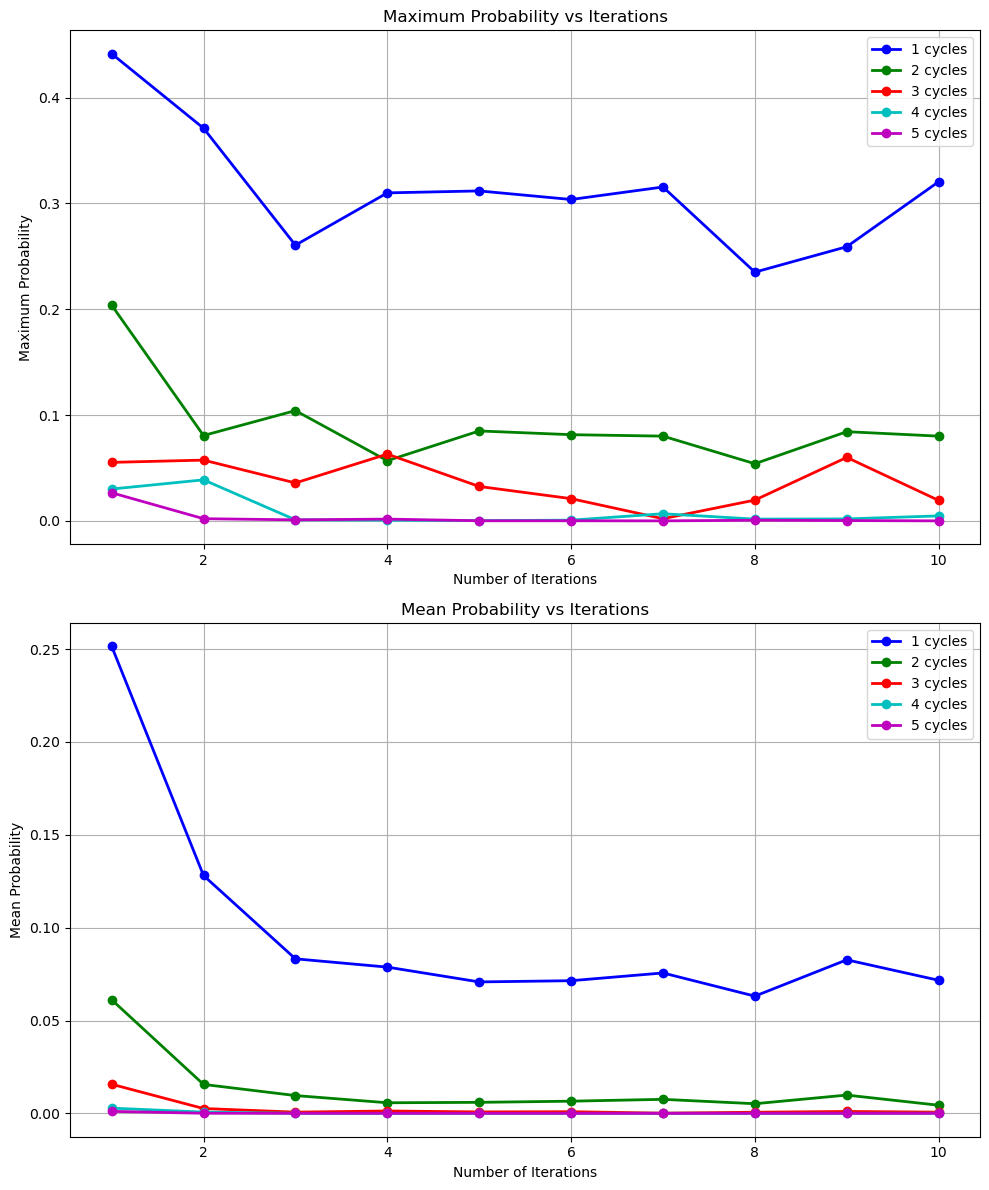


Summary Statistics:

For Maximum Probabilities:
            mean       std       min       max
cycles                                        
1       0.312881  0.059424  0.235059  0.441504
2       0.091045  0.042132  0.054004  0.203906
3       0.036611  0.021265  0.002051  0.063086
4       0.008633  0.013897  0.000195  0.038770
5       0.003232  0.008229  0.000000  0.026562

For Mean Probabilities:
            mean       std       min       max
cycles                                        
1       0.097687  0.056927  0.063121  0.251556
2       0.013154  0.017193  0.004372  0.061195
3       0.002430  0.004700  0.000136  0.015677
4       0.000382  0.000879  0.000008  0.002817
5       0.000119  0.000336  0.000000  0.001074


In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('noise_data.csv')

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
fig.tight_layout(pad=4.0)  # Add some space between subplots

# Plot maximum probabilities
colors = ['b', 'g', 'r', 'c', 'm']  # Different colors for each cycle number
for i, cycle in enumerate(sorted(df['cycles'].unique())):
    cycle_data = df[df['cycles'] == cycle]
    ax1.plot(cycle_data['iterations'], 
             cycle_data['max_probability'], 
             color=colors[i],
             marker='o', 
             label=f'{cycle} cycles',
             linewidth=2)

ax1.set_xlabel('Number of Iterations')
ax1.set_ylabel('Maximum Probability')
ax1.set_title('Maximum Probability vs Iterations')
ax1.legend()
ax1.grid(True)

# Plot mean probabilities
for i, cycle in enumerate(sorted(df['cycles'].unique())):
    cycle_data = df[df['cycles'] == cycle]
    ax2.plot(cycle_data['iterations'], 
             cycle_data['mean_probability'], 
             color=colors[i],
             marker='o', 
             label=f'{cycle} cycles',
             linewidth=2)

ax2.set_xlabel('Number of Iterations')
ax2.set_ylabel('Mean Probability')
ax2.set_title('Mean Probability vs Iterations')
ax2.legend()
ax2.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.savefig('probability_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print some summary statistics
print("\nSummary Statistics:")
print("\nFor Maximum Probabilities:")
stats_max = df.groupby('cycles')['max_probability'].agg(['mean', 'std', 'min', 'max'])
print(stats_max)

print("\nFor Mean Probabilities:")
stats_mean = df.groupby('cycles')['mean_probability'].agg(['mean', 'std', 'min', 'max'])
print(stats_mean)

In [6]:
gamma = 0.5
cycles = 3
tsamples = ((1 / gamma) * np.abs(np.random.randn(cycles))).tolist()

In [7]:
tsamples

[0.930397727735335, 0.869024460470899, 2.1834044119132288]


Required sigma values for target time 2.0
1 cycles, 3 iterations: sigma = 2.865
2 cycles, 2 iterations: sigma = 1.671
3 cycles, 2 iterations: sigma = 1.114


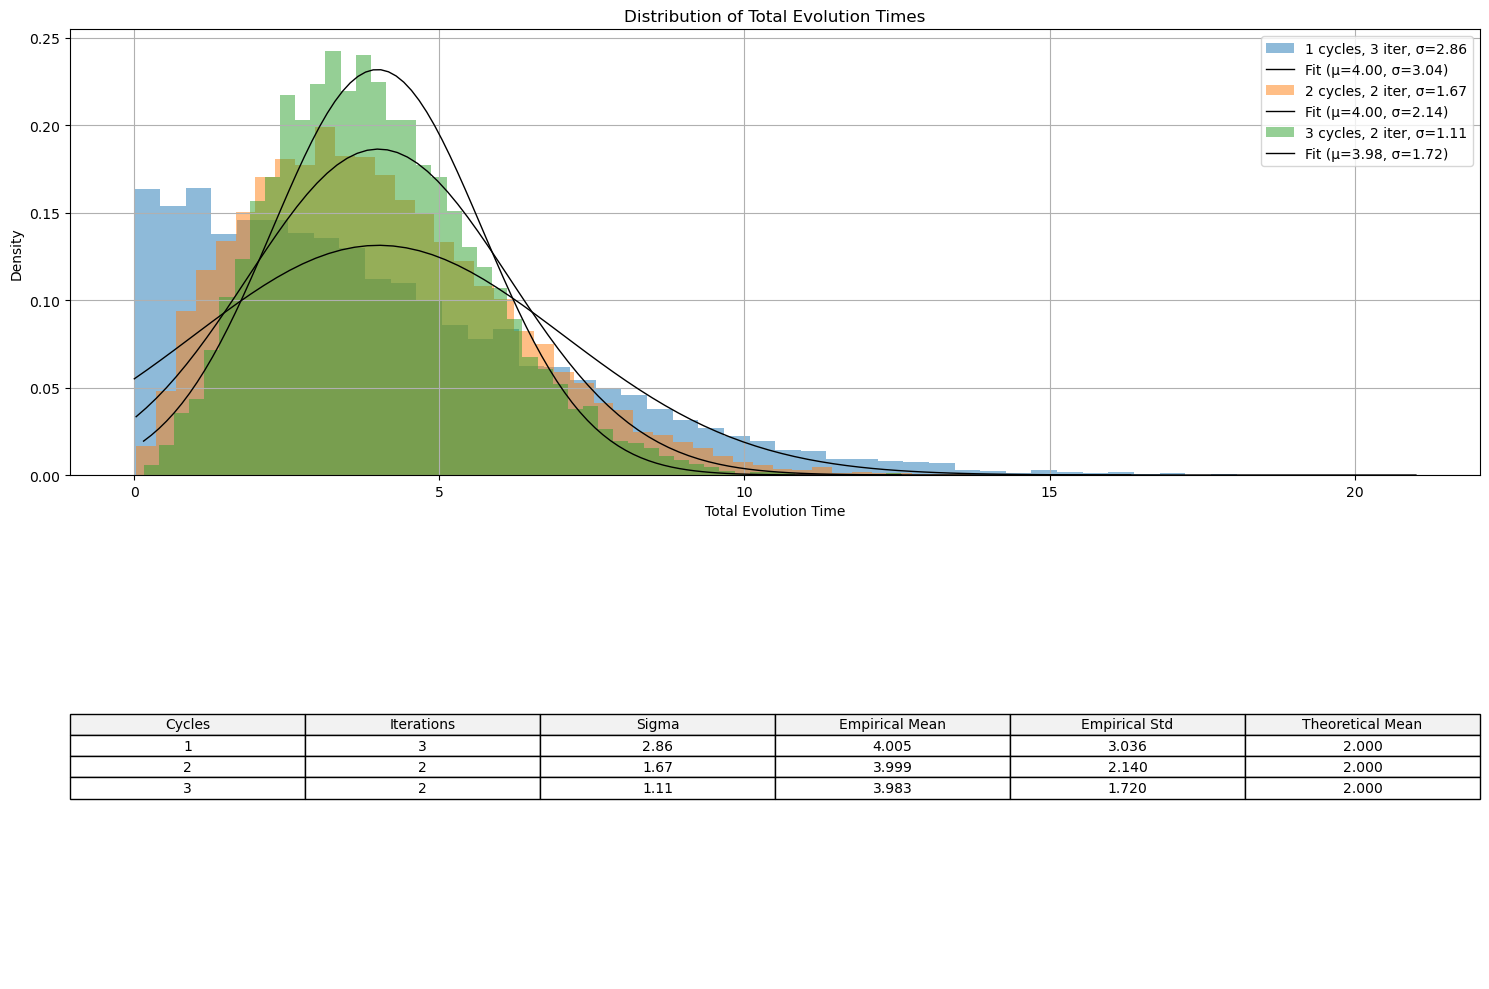

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def calculate_evolution_times(n_cycles, iterations_per_cycle, sigma, n_samples=10000):
    """
    Calculate total evolution times for given number of cycles and iterations.
    
    Parameters:
    -----------
    n_cycles : int
        Number of cycles
    iterations_per_cycle : int
        Number of iterations per cycle
    sigma : float
        Standard deviation for the Gaussian distribution
    n_samples : int
        Number of samples to generate
    
    Returns:
    --------
    total_times : ndarray
        Array of total evolution times
    theoretical_mean : float
        Expected mean total time
    """
    total_times = np.zeros(n_samples)
    
    for sample in range(n_samples):
        time = 0
        for cycle in range(n_cycles):
            # Sample initial time from Gaussian and take absolute value
            t = abs(np.random.normal(0, sigma))
            # Add up time for all iterations in this cycle
            for i in range(iterations_per_cycle):
                time += t / (2**i)
        total_times[sample] = time
    
    # Calculate theoretical mean using the formula sqrt(2/π)*sigma*(1-1/2^k)
    theoretical_mean = n_cycles * np.sqrt(2/np.pi) * sigma * (1 - 1/2**iterations_per_cycle)
    
    return total_times, theoretical_mean

def plot_time_distributions(combinations, n_samples=10000):
    """
    Plot distributions of total evolution times for different combinations.
    
    Parameters:
    -----------
    combinations : list of tuples
        List of (n_cycles, iterations_per_cycle, sigma) combinations
    n_samples : int
        Number of samples per combination
    """
    plt.figure(figsize=(15, 10))
    
    # Create subplots for histogram and stats
    plt.subplot(2, 1, 1)
    
    results = []
    for n_cycles, iterations, sigma in combinations:
        times, theo_mean = calculate_evolution_times(n_cycles, iterations, sigma, n_samples)
        
        # Plot histogram
        plt.hist(times, bins=50, alpha=0.5, density=True, 
                label=f'{n_cycles} cycles, {iterations} iter, σ={sigma:.2f}')
        
        # Fit normal distribution and plot
        mu, std = stats.norm.fit(times)
        x = np.linspace(min(times), max(times), 100)
        p = stats.norm.pdf(x, mu, std)
        plt.plot(x, p, 'k', linewidth=1, 
                label=f'Fit (μ={mu:.2f}, σ={std:.2f})')
        
        results.append({
            'cycles': n_cycles,
            'iterations': iterations,
            'sigma': sigma,
            'empirical_mean': np.mean(times),
            'empirical_std': np.std(times),
            'theoretical_mean': theo_mean
        })
    
    plt.xlabel('Total Evolution Time')
    plt.ylabel('Density')
    plt.title('Distribution of Total Evolution Times')
    plt.legend()
    plt.grid(True)
    
    # Create table of statistics
    plt.subplot(2, 1, 2)
    plt.axis('off')
    
    cell_text = []
    for r in results:
        cell_text.append([
            f"{r['cycles']}", 
            f"{r['iterations']}", 
            f"{r['sigma']:.2f}",
            f"{r['empirical_mean']:.3f}",
            f"{r['empirical_std']:.3f}",
            f"{r['theoretical_mean']:.3f}"
        ])
    
    columns = ['Cycles', 'Iterations', 'Sigma', 
               'Empirical Mean', 'Empirical Std', 'Theoretical Mean']
    
    plt.table(cellText=cell_text, colLabels=columns, 
             loc='center', cellLoc='center',
             colColours=['#f2f2f2']*len(columns))
    
    plt.tight_layout()
    return results

# Test different combinations
combinations = [
    (1, 3, 1.0),   # 1 cycle, 3 iterations, baseline sigma
    (2, 2, 1.2),   # 2 cycles, 2 iterations, adjusted sigma
    (3, 2, 0.8),   # 3 cycles, 2 iterations, adjusted sigma
]

# Function to calculate required sigma for target time
def calculate_required_sigma(n_cycles, iterations, target_time):
    """
    Calculate required sigma to achieve target average total time.
    
    Parameters:
    -----------
    n_cycles : int
        Number of cycles
    iterations : int
        Number of iterations per cycle
    target_time : float
        Desired average total time
    
    Returns:
    --------
    sigma : float
        Required sigma value
    """
    # Using the formula: target = n_cycles * sqrt(2/π) * sigma * (1-1/2^k)
    # Solve for sigma
    return target_time / (n_cycles * np.sqrt(2/np.pi) * (1 - 1/2**iterations))

# Example usage:
target_time = 2.0
print("\nRequired sigma values for target time", target_time)
for cycles, iterations, _ in combinations:
    sigma = calculate_required_sigma(cycles, iterations, target_time)
    print(f"{cycles} cycles, {iterations} iterations: sigma = {sigma:.3f}")

# Plot distributions with calculated sigma values
adjusted_combinations = [(c, i, calculate_required_sigma(c, i, target_time)) 
                        for c, i, _ in combinations]
results = plot_time_distributions(adjusted_combinations)
plt.show()


Summary of results:
Target time: 2.0

Statistics across all combinations:
          cycles  iterations      sigma  empirical_mean  empirical_std  \
count  50.000000   50.000000  50.000000       50.000000      50.000000   
mean    3.000000    5.500000   1.328499        3.993775       1.945198   
std     1.428571    2.901442   0.944456        0.031810       0.599167   
min     1.000000    1.000000   0.501816        3.916858       1.329193   
25%     2.000000    3.000000   0.639171        3.975366       1.499848   
50%     3.000000    5.500000   0.923076        3.994557       1.742348   
75%     4.000000    8.000000   1.611404        4.010934       2.130952   
max     5.000000   10.000000   5.013257        4.058525       3.048432   

       theoretical_mean  relative_std   max_time   min_time  
count      5.000000e+01     50.000000  50.000000  50.000000  
mean       2.000000e+00      0.487195  13.243439   0.242350  
std        8.971957e-17      0.150555   3.430452   0.229010  
min       

KeyError: "None of [Index([2.0325668078514685, 1.9250869479339556, 1.9745177838418275,\n        2.035650364029773, 1.9260709162460712,   2.00905998308595,\n       1.9708028046763402, 2.0233952370228323,  2.042130669500443,\n        1.944392176598277,  2.004008530989088, 1.9779093137975439,\n       1.9934867654168813, 2.0005575817697547, 2.0585252166118977,\n       1.9637335713355482, 2.0269610679979992, 1.9879487254159396,\n        1.997101348821666, 1.9168579093226668,  2.011177699672605,\n        2.008697691149533, 1.9410539758096927, 1.9855350026390295,\n        2.055271625457144, 1.9784771952215423, 1.9576866014699683,\n       1.9697433323016762,  1.979368933975826, 2.0008083407507655,\n       2.0056642050774967,  2.025917372951538, 2.0282279043731632,\n       1.9956272503834946, 2.0275596055513914, 1.9829220564988703,\n       1.9849280718390059, 1.9993167299702121, 2.0315976764616277,\n        1.998174979238199,  2.008324378313392, 1.9710553861288616,\n       2.0234966226825524, 1.9737900709972362, 2.0102033558807886,\n       1.9846499069379293,  1.984014884316788, 1.9714813176742334,\n       1.9922317053960792, 1.9909712227565848],\n      dtype='float64')] are in the [columns]"

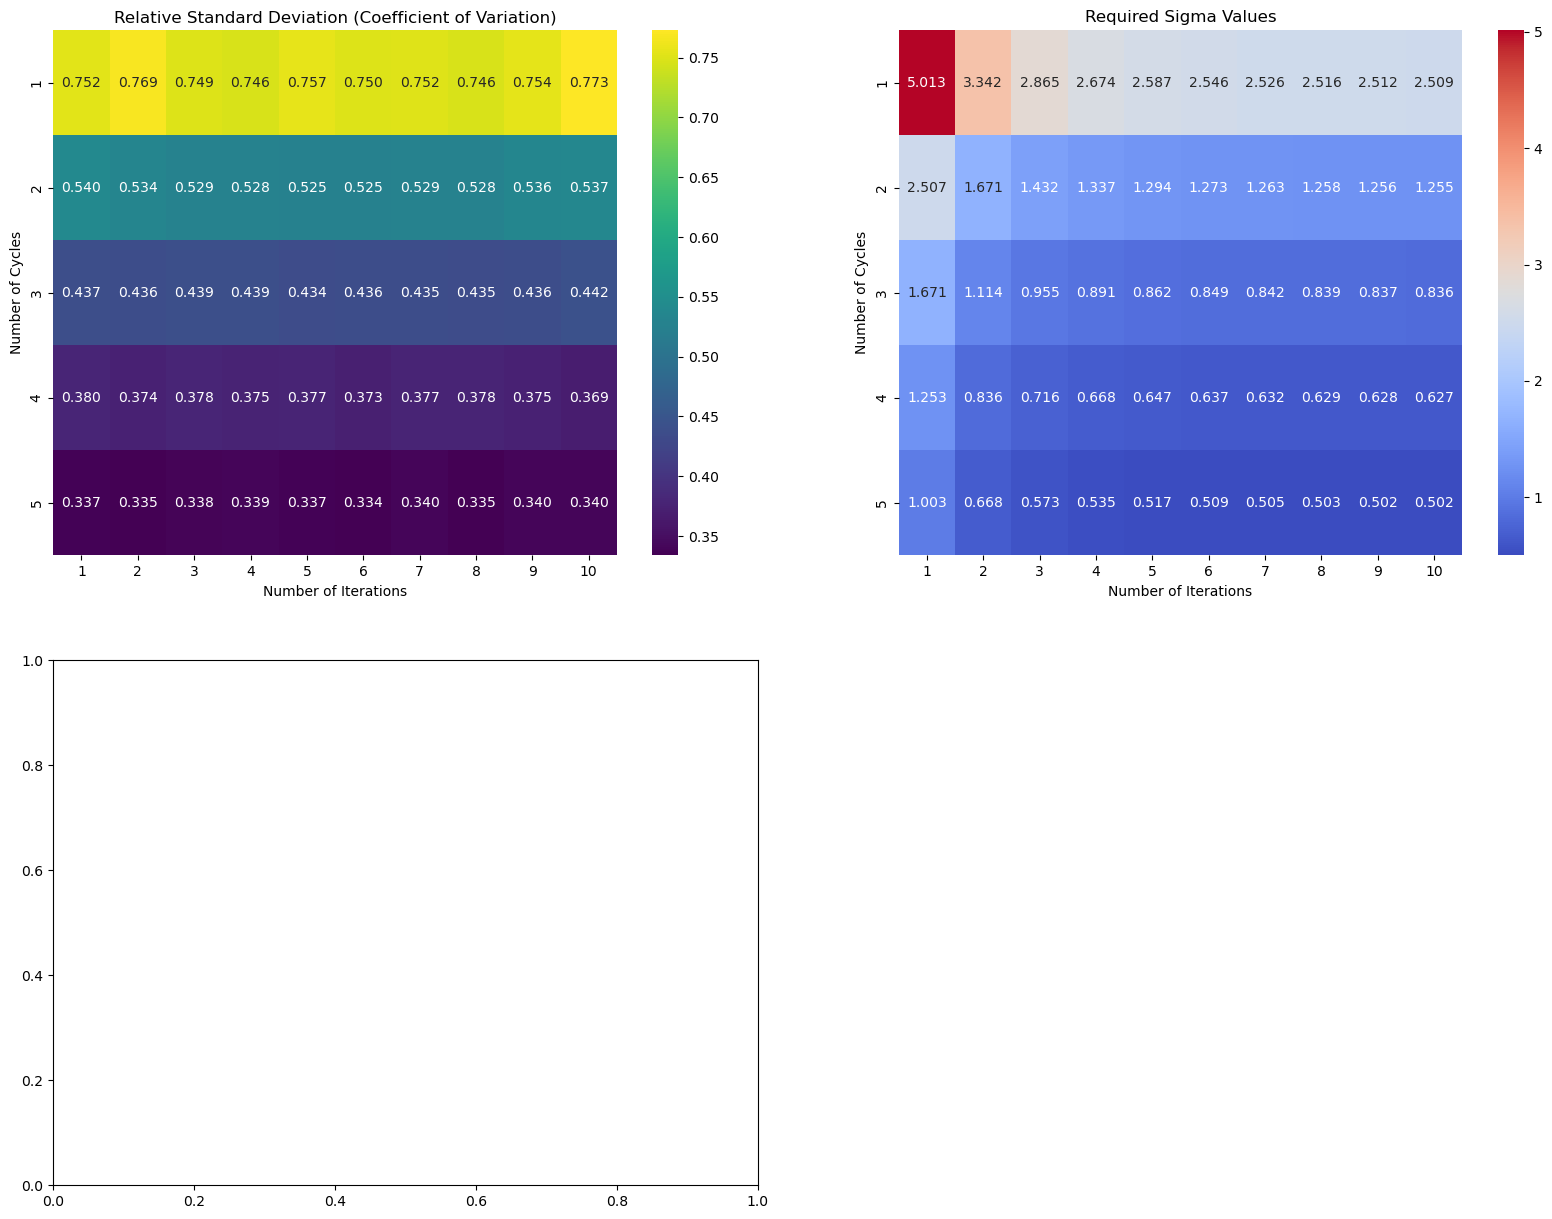

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns

def calculate_evolution_times(n_cycles, iterations_per_cycle, sigma, n_samples=5000):
    """Calculate total evolution times for given number of cycles and iterations."""
    total_times = np.zeros(n_samples)
    
    for sample in range(n_samples):
        time = 0
        for cycle in range(n_cycles):
            t = abs(np.random.normal(0, sigma))
            for i in range(iterations_per_cycle):
                time += t / (2**i)
        total_times[sample] = time
    
    theoretical_mean = n_cycles * np.sqrt(2/np.pi) * sigma * (1 - 1/2**iterations_per_cycle)
    
    return total_times, theoretical_mean

def calculate_required_sigma(n_cycles, iterations, target_time):
    """Calculate required sigma to achieve target average total time."""
    return target_time / (n_cycles * np.sqrt(2/np.pi) * (1 - 1/2**iterations))

def analyze_combinations(max_cycles=5, max_iterations=10, target_time=2.0, n_samples=5000):
    """Analyze various combinations of cycles and iterations."""
    results = []
    
    for cycles in range(1, max_cycles + 1):
        for iterations in range(1, max_iterations + 1):
            # Calculate required sigma for target time
            sigma = calculate_required_sigma(cycles, iterations, target_time)
            
            # Calculate times and statistics
            times, theo_mean = calculate_evolution_times(cycles, iterations, sigma, n_samples)
            
            results.append({
                'cycles': cycles,
                'iterations': iterations,
                'sigma': sigma,
                'empirical_mean': np.mean(times),
                'empirical_std': np.std(times),
                'theoretical_mean': theo_mean,
                'relative_std': np.std(times) / np.mean(times),  # Coefficient of variation
                'max_time': np.max(times),
                'min_time': np.min(times)
            })
    
    return pd.DataFrame(results)

def plot_comprehensive_analysis(df):
    """Create comprehensive visualizations of the analysis."""
    plt.figure(figsize=(20, 15))
    
    # Plot 1: Heatmap of relative standard deviation
    plt.subplot(2, 2, 1)
    pivot_rel_std = df.pivot(index='cycles', columns='iterations', values='relative_std')
    sns.heatmap(pivot_rel_std, annot=True, fmt='.3f', cmap='viridis')
    plt.title('Relative Standard Deviation (Coefficient of Variation)')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Number of Cycles')
    
    # Plot 2: Required sigma values
    plt.subplot(2, 2, 2)
    pivot_sigma = df.pivot(index='cycles', columns='iterations', values='sigma')
    sns.heatmap(pivot_sigma, annot=True, fmt='.3f', cmap='coolwarm')
    plt.title('Required Sigma Values')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Number of Cycles')
    
    # Plot 3: Empirical vs Theoretical Mean Difference
    plt.subplot(2, 2, 3)
    mean_diff = df.pivot(index='cycles', 
                        columns='iterations', 
                        values=df['empirical_mean'] - df['theoretical_mean'])
    sns.heatmap(mean_diff, annot=True, fmt='.3f', cmap='RdYlBu')
    plt.title('Empirical - Theoretical Mean Difference')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Number of Cycles')
    
    # Plot 4: Max/Min Time Range
    plt.subplot(2, 2, 4)
    time_range = df.pivot(index='cycles', 
                         columns='iterations', 
                         values=df['max_time'] - df['min_time'])
    sns.heatmap(time_range, annot=True, fmt='.3f', cmap='magma')
    plt.title('Time Range (Max - Min)')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Number of Cycles')
    
    plt.tight_layout()
    plt.show()

    # Additional plots for specific relationships
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    for cycles in range(1, max_cycles + 1):
        cycle_data = df[df['cycles'] == cycles]
        plt.plot(cycle_data['iterations'], 
                cycle_data['relative_std'], 
                'o-', 
                label=f'{cycles} cycles')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Relative Standard Deviation')
    plt.title('Effect of Iterations on Relative Std Dev')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    for iterations in range(1, max_iterations + 1, 2):
        iter_data = df[df['iterations'] == iterations]
        plt.plot(iter_data['cycles'], 
                iter_data['sigma'], 
                'o-', 
                label=f'{iterations} iterations')
    plt.xlabel('Number of Cycles')
    plt.ylabel('Required Sigma')
    plt.title('Required Sigma vs Number of Cycles')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Run analysis
target_time = 2.0
results_df = analyze_combinations(max_cycles=5, max_iterations=10, target_time=target_time)

# Display summary statistics
print("\nSummary of results:")
print(f"Target time: {target_time}")
print("\nStatistics across all combinations:")
print(results_df.describe())

# Create visualizations
plot_comprehensive_analysis(results_df)
